In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torchvision.ops
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
raw_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
train_dir=raw_image_dir

In [4]:
train_fns = os.listdir(raw_image_dir)
val_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10")
print(len(train_fns), len(val_fns))

8000 234


In [5]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

transform = T.Resize(size = (256,256))


C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100\05000_RV.png


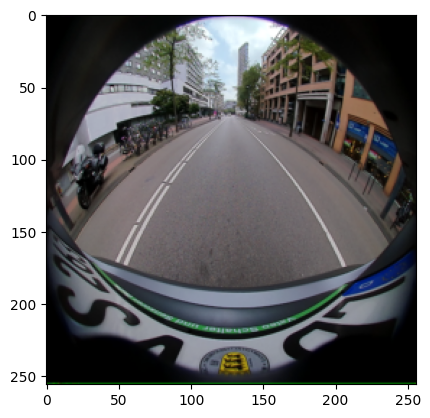

In [6]:
sample_image_fp = os.path.join(train_dir, train_fns[5000])
sample_image = transform(Image.open(sample_image_fp)).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [7]:
train_label_fns = os.listdir(label_image_dir)
val_label_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10")
print(len(train_label_fns), len(val_label_fns))

8000 234


C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100\05000_RV.png


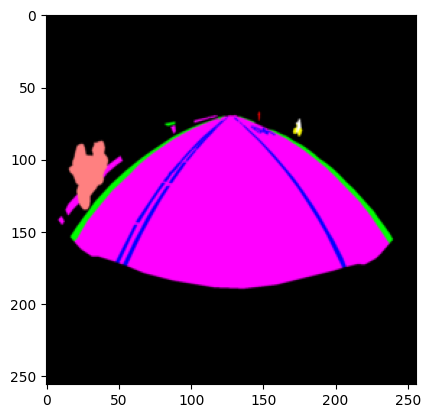

In [8]:
sample_label_fp = os.path.join(label_image_dir, train_label_fns[5000])
sample_label = transform(Image.open(sample_label_fp)).convert("RGB")
plt.imshow(sample_label)
print(sample_label_fp)

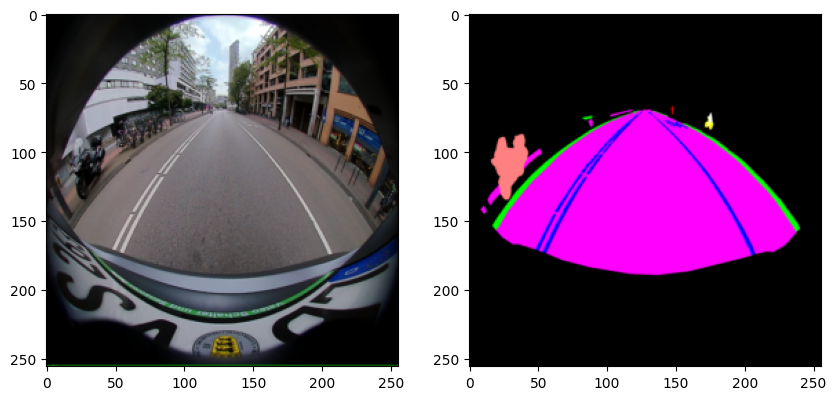

In [9]:

woodscape, label = Image.fromarray(np.array(sample_image)), Image.fromarray(np.array(sample_label))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)

In [10]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [11]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

C:\Users\yashs\Woodscape\woodscape_cuda_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [12]:
sample_label = label.convert("RGB")

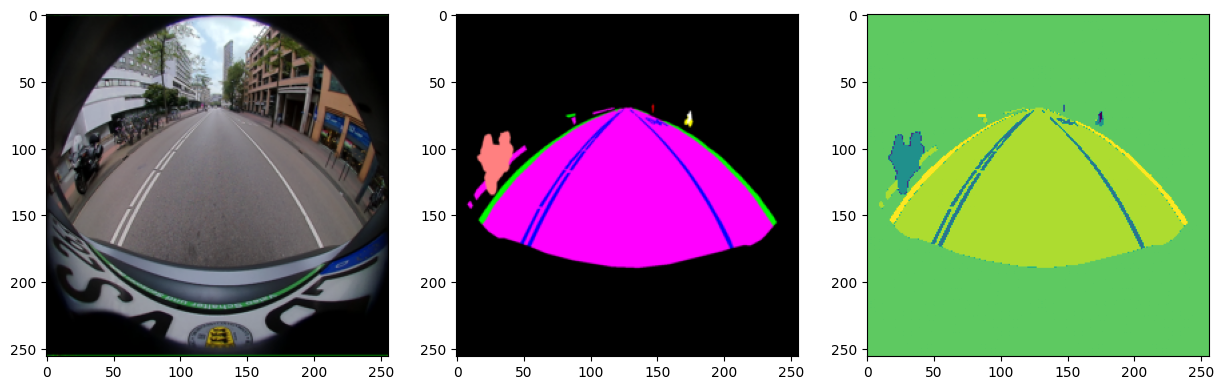

In [13]:
woodscape, label = np.array(sample_image),np.array(sample_label)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [14]:
label_class

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])

In [15]:
class WoodscapeDataset(Dataset):

  def __init__(self, image_dir, label_dir, label_model):
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.image_fns = os.listdir(image_dir)
    self.label_fns = os.listdir(label_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    label_fn = self.label_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    label_fp = os.path.join(self.label_dir, label_fn)
    image = transform(Image.open(image_fp)).convert("RGB")
    label = transform(Image.open(label_fp)).convert("RGB")
    image = np.array(image)
    woodscape = np.array(image)
    label = np.array(label)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    woodscape = self.transform(woodscape)
    return woodscape, label_class

  def split_image(self, image):
    image = np.array(image)
    woodscape, label = image[:, :256, :], image[:, 256:, :]
    return woodscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [16]:
train_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
print(len(dataset))

8000


In [17]:
woodscape, label_class = dataset[0]
print(woodscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [18]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        # h, w = x.shape[2:]
        # max_offset = max(h, w)/4.

        offset = self.offset_conv(x)  # .clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        # op = (n - (k * d - 1) + 2p / s)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [19]:
class DUNet(nn.Module):
    
    def __init__(self, num_classes):
        super(DUNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = DeformableConv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = DeformableConv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [20]:
model = DUNet(num_classes=num_classes)

In [29]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).__next__()
print(X.shape, Y.shape)

8000 2000
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [30]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [31]:
batch_size = 4
epochs = 25
lr = 0.00001
weight_decay=0.001

In [32]:
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [33]:
model = DUNet(num_classes = num_classes).to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr,weight_decay=weight_decay)

In [28]:
import time
step_losses = []
epoch_losses = []

total_start = time.time()
for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    print("--------------------- Epoch number: "+str(epoch)+" ---------------------------------")
    epoch_loss = 0
    counter = 0
    for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
        counter=counter+1
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        if counter%500==0:
            print("step number",counter)
            print("epoch_loss : ",epoch_loss)
            print("step_losses : ",loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    epoch_end = time.time()
    print("Epoch Time Taken",epoch_end - epoch_start)
total_end = time.time()
print("Total Time Taken",total_end - total_start)

  0%|          | 0/25 [00:00<?, ?it/s]

--------------------- Epoch number: 0 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  567.5972765386105
step_losses :  0.46171027421951294
step number 1000
epoch_loss :  770.2136920839548
step_losses :  0.28682219982147217
step number 1500
epoch_loss :  928.287364885211
step_losses :  0.19450098276138306
step number 2000
epoch_loss :  1049.0613833591342
step_losses :  0.20932741463184357
Epoch Time Taken 1453.1286437511444
--------------------- Epoch number: 1 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  137.73801593482494
step_losses :  0.19407600164413452
step number 1000
epoch_loss :  260.3940214961767
step_losses :  0.17822223901748657
step number 1500
epoch_loss :  375.36569883674383
step_losses :  0.13848067820072174
step number 2000
epoch_loss :  464.39552886784077
step_losses :  0.16346091032028198
Epoch Time Taken 1459.9279475212097
--------------------- Epoch number: 2 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  110.5719658061862
step_losses :  0.15277718007564545
step number 1000
epoch_loss :  212.03727344423532
step_losses :  0.15871696174144745
step number 1500
epoch_loss :  310.1990495622158
step_losses :  0.12024331092834473
step number 2000
epoch_loss :  384.3364702127874
step_losses :  0.14883610606193542
Epoch Time Taken 1462.245634317398
--------------------- Epoch number: 3 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  96.8798264786601
step_losses :  0.13837330043315887
step number 1000
epoch_loss :  186.28411376476288
step_losses :  0.14855846762657166
step number 1500
epoch_loss :  273.79636693000793
step_losses :  0.11058791726827621
step number 2000
epoch_loss :  337.3405373431742
step_losses :  0.12224803119897842
Epoch Time Taken 1464.8129947185516
--------------------- Epoch number: 4 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  87.15622595697641
step_losses :  0.12843753397464752
step number 1000
epoch_loss :  168.10536853969097
step_losses :  0.13759730756282806
step number 1500
epoch_loss :  247.85240756720304
step_losses :  0.10295485705137253
step number 2000
epoch_loss :  304.6633280329406
step_losses :  0.11391720175743103
Epoch Time Taken 1465.4902782440186
--------------------- Epoch number: 5 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  80.45029672980309
step_losses :  0.1172444075345993
step number 1000
epoch_loss :  154.95987355709076
step_losses :  0.13237681984901428
step number 1500
epoch_loss :  227.84317015856504
step_losses :  0.09676726162433624
step number 2000
epoch_loss :  279.1325502805412
step_losses :  0.1026688814163208
Epoch Time Taken 1464.637372970581
--------------------- Epoch number: 6 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  73.3253888450563
step_losses :  0.10873091965913773
step number 1000
epoch_loss :  142.19076073542237
step_losses :  0.12444008886814117
step number 1500
epoch_loss :  208.74866414442658
step_losses :  0.09486842900514603
step number 2000
epoch_loss :  254.5691718161106
step_losses :  0.09613065421581268
Epoch Time Taken 1466.3655469417572
--------------------- Epoch number: 7 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  67.12510954588652
step_losses :  0.10141731798648834
step number 1000
epoch_loss :  129.55010909214616
step_losses :  0.12260861694812775
step number 1500
epoch_loss :  190.85154565051198
step_losses :  0.08682873100042343
step number 2000
epoch_loss :  232.7213148549199
step_losses :  0.09483959525823593
Epoch Time Taken 1466.0462369918823
--------------------- Epoch number: 8 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  62.1964076384902
step_losses :  0.09604067355394363
step number 1000
epoch_loss :  121.08892920985818
step_losses :  0.11062875390052795
step number 1500
epoch_loss :  179.59449772536755
step_losses :  0.08332253992557526
step number 2000
epoch_loss :  219.06115064769983
step_losses :  0.0846511572599411
Epoch Time Taken 1467.0176396369934
--------------------- Epoch number: 9 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  59.479884188622236
step_losses :  0.09261215478181839
step number 1000
epoch_loss :  114.74411061778665
step_losses :  0.104792520403862
step number 1500
epoch_loss :  169.81994685903192
step_losses :  0.08061660826206207
step number 2000
epoch_loss :  206.92220894992352
step_losses :  0.07889117300510406
Epoch Time Taken 1466.4307215213776
--------------------- Epoch number: 10 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  54.186591517180204
step_losses :  0.10375538468360901
step number 1000
epoch_loss :  106.09073317423463
step_losses :  0.10774905234575272
step number 1500
epoch_loss :  158.1577200256288
step_losses :  0.07764911651611328
step number 2000
epoch_loss :  193.1281942613423
step_losses :  0.07491771876811981
Epoch Time Taken 1468.7488586902618
--------------------- Epoch number: 11 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  52.879904977977276
step_losses :  0.08711415529251099
step number 1000
epoch_loss :  103.31023843213916
step_losses :  0.10171298682689667
step number 1500
epoch_loss :  154.0977218300104
step_losses :  0.07853555679321289
step number 2000
epoch_loss :  188.7897506095469
step_losses :  0.07580907642841339
Epoch Time Taken 1467.81245303154
--------------------- Epoch number: 12 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  48.90453815087676
step_losses :  0.0854051411151886
step number 1000
epoch_loss :  95.37968264147639
step_losses :  0.09966090321540833
step number 1500
epoch_loss :  143.5003758072853
step_losses :  0.07588560879230499
step number 2000
epoch_loss :  175.7964538782835
step_losses :  0.06808975338935852
Epoch Time Taken 1469.7995483875275
--------------------- Epoch number: 13 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  49.00046021491289
step_losses :  0.07948291301727295
step number 1000
epoch_loss :  92.92436934262514
step_losses :  0.08532823622226715
step number 1500
epoch_loss :  137.97563068568707
step_losses :  0.07233568280935287
step number 2000
epoch_loss :  168.6017471961677
step_losses :  0.06553619354963303
Epoch Time Taken 1467.1692695617676
--------------------- Epoch number: 14 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  47.09048230201006
step_losses :  0.07870063185691833
step number 1000
epoch_loss :  91.54853145033121
step_losses :  0.09149797260761261
step number 1500
epoch_loss :  137.06542833521962
step_losses :  0.07305122911930084
step number 2000
epoch_loss :  167.48620627820492
step_losses :  0.06481990218162537
Epoch Time Taken 1465.2738497257233
--------------------- Epoch number: 15 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  43.18206984549761
step_losses :  0.07451530545949936
step number 1000
epoch_loss :  84.96794801577926
step_losses :  0.08371137827634811
step number 1500
epoch_loss :  129.9171060398221
step_losses :  0.07072116434574127
step number 2000
epoch_loss :  158.8612014092505
step_losses :  0.06759316474199295
Epoch Time Taken 1469.2090306282043
--------------------- Epoch number: 16 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  40.885569367557764
step_losses :  0.07216024398803711
step number 1000
epoch_loss :  80.12639375030994
step_losses :  0.07947562634944916
step number 1500
epoch_loss :  121.76680860295892
step_losses :  0.06883460283279419
step number 2000
epoch_loss :  151.19222129881382
step_losses :  0.07169057428836823
Epoch Time Taken 1462.9255306720734
--------------------- Epoch number: 17 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  42.18179631233215
step_losses :  0.06827686727046967
step number 1000
epoch_loss :  81.65137888863683
step_losses :  0.07588395476341248
step number 1500
epoch_loss :  121.9967192709446
step_losses :  0.06914936751127243
step number 2000
epoch_loss :  150.54571862146258
step_losses :  0.05831347405910492
Epoch Time Taken 1462.2792468070984
--------------------- Epoch number: 18 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  41.54538133740425
step_losses :  0.0667792558670044
step number 1000
epoch_loss :  79.1623004488647
step_losses :  0.07637733221054077
step number 1500
epoch_loss :  117.6674567759037
step_losses :  0.0651036873459816
step number 2000
epoch_loss :  144.3831395097077
step_losses :  0.06358733028173447
Epoch Time Taken 1460.9246788024902
--------------------- Epoch number: 19 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  38.18447730317712
step_losses :  0.06653672456741333
step number 1000
epoch_loss :  74.55539931356907
step_losses :  0.07145121693611145
step number 1500
epoch_loss :  112.18315486982465
step_losses :  0.0642162337899208
step number 2000
epoch_loss :  138.17898951284587
step_losses :  0.06453468650579453
Epoch Time Taken 1462.8630957603455
--------------------- Epoch number: 20 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  36.88521236181259
step_losses :  0.0633007064461708
step number 1000
epoch_loss :  72.4425559900701
step_losses :  0.06852422654628754
step number 1500
epoch_loss :  109.86674032360315
step_losses :  0.0661683976650238
step number 2000
epoch_loss :  135.70842946320772
step_losses :  0.05525592714548111
Epoch Time Taken 1467.5721514225006
--------------------- Epoch number: 21 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  35.64206552878022
step_losses :  0.06392979621887207
step number 1000
epoch_loss :  72.3000604249537
step_losses :  0.07133831083774567
step number 1500
epoch_loss :  109.74272779747844
step_losses :  0.06183750927448273
step number 2000
epoch_loss :  135.98736327327788
step_losses :  0.051471807062625885
Epoch Time Taken 1466.9015958309174
--------------------- Epoch number: 22 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  39.49838041886687
step_losses :  0.07911317050457001
step number 1000
epoch_loss :  75.71070848032832
step_losses :  0.06839493662118912
step number 1500
epoch_loss :  110.3357262648642
step_losses :  0.05867820233106613
step number 2000
epoch_loss :  136.37678489647806
step_losses :  0.048080090433359146
Epoch Time Taken 1463.646450996399
--------------------- Epoch number: 23 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  34.13503962010145
step_losses :  0.07054108381271362
step number 1000
epoch_loss :  66.51931012049317
step_losses :  0.06069716811180115
step number 1500
epoch_loss :  99.19984420016408
step_losses :  0.05568611994385719
step number 2000
epoch_loss :  122.88159645348787
step_losses :  0.045944880694150925
Epoch Time Taken 1340.662150144577
--------------------- Epoch number: 24 ---------------------------------


  0%|          | 0/2000 [00:00<?, ?it/s]

step number 500
epoch_loss :  33.19912091642618
step_losses :  0.05593851953744888
step number 1000
epoch_loss :  71.46350644156337
step_losses :  0.0742110162973404
step number 1500
epoch_loss :  107.5592138171196
step_losses :  0.05761761963367462
step number 2000
epoch_loss :  132.8453271370381
step_losses :  0.04690156131982803
Epoch Time Taken 1320.3819041252136
Total Time Taken 36352.291826963425


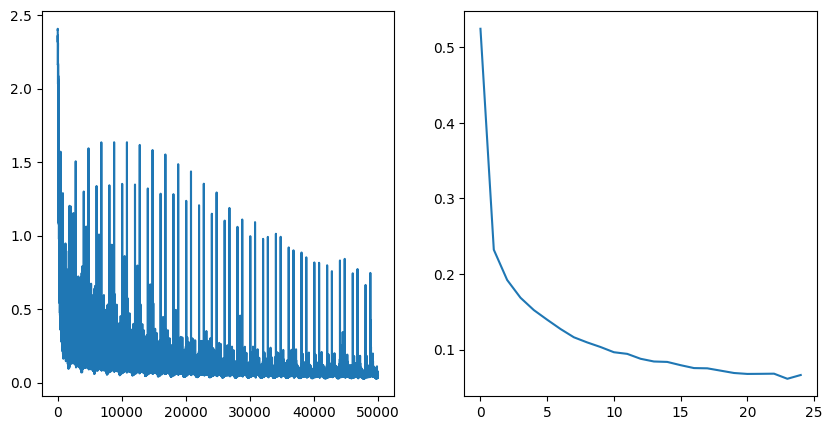

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [32]:
model_name = "Deformable_U-Net_8000_v11_lastAndM_D_25_epoch.pth"
torch.save(model.state_dict(), model_name)

In [21]:
device = "cpu"
device = torch.device(device)
print(device)

cpu


In [22]:
model_path = "Deformable_U-Net_8000_v11_lastAndM_D_25_epoch.pth"
model_ = DUNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
test_batch_size = 10
val_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10"
val_label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10"
dataset = WoodscapeDataset(val_dir,val_label_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [24]:
import time
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
pred_time_start=time.time()
Y_pred = model_(X)
pred_time_end=time.time()
mean_pred_time=(pred_time_end-pred_time_start)/test_batch_size
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [25]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

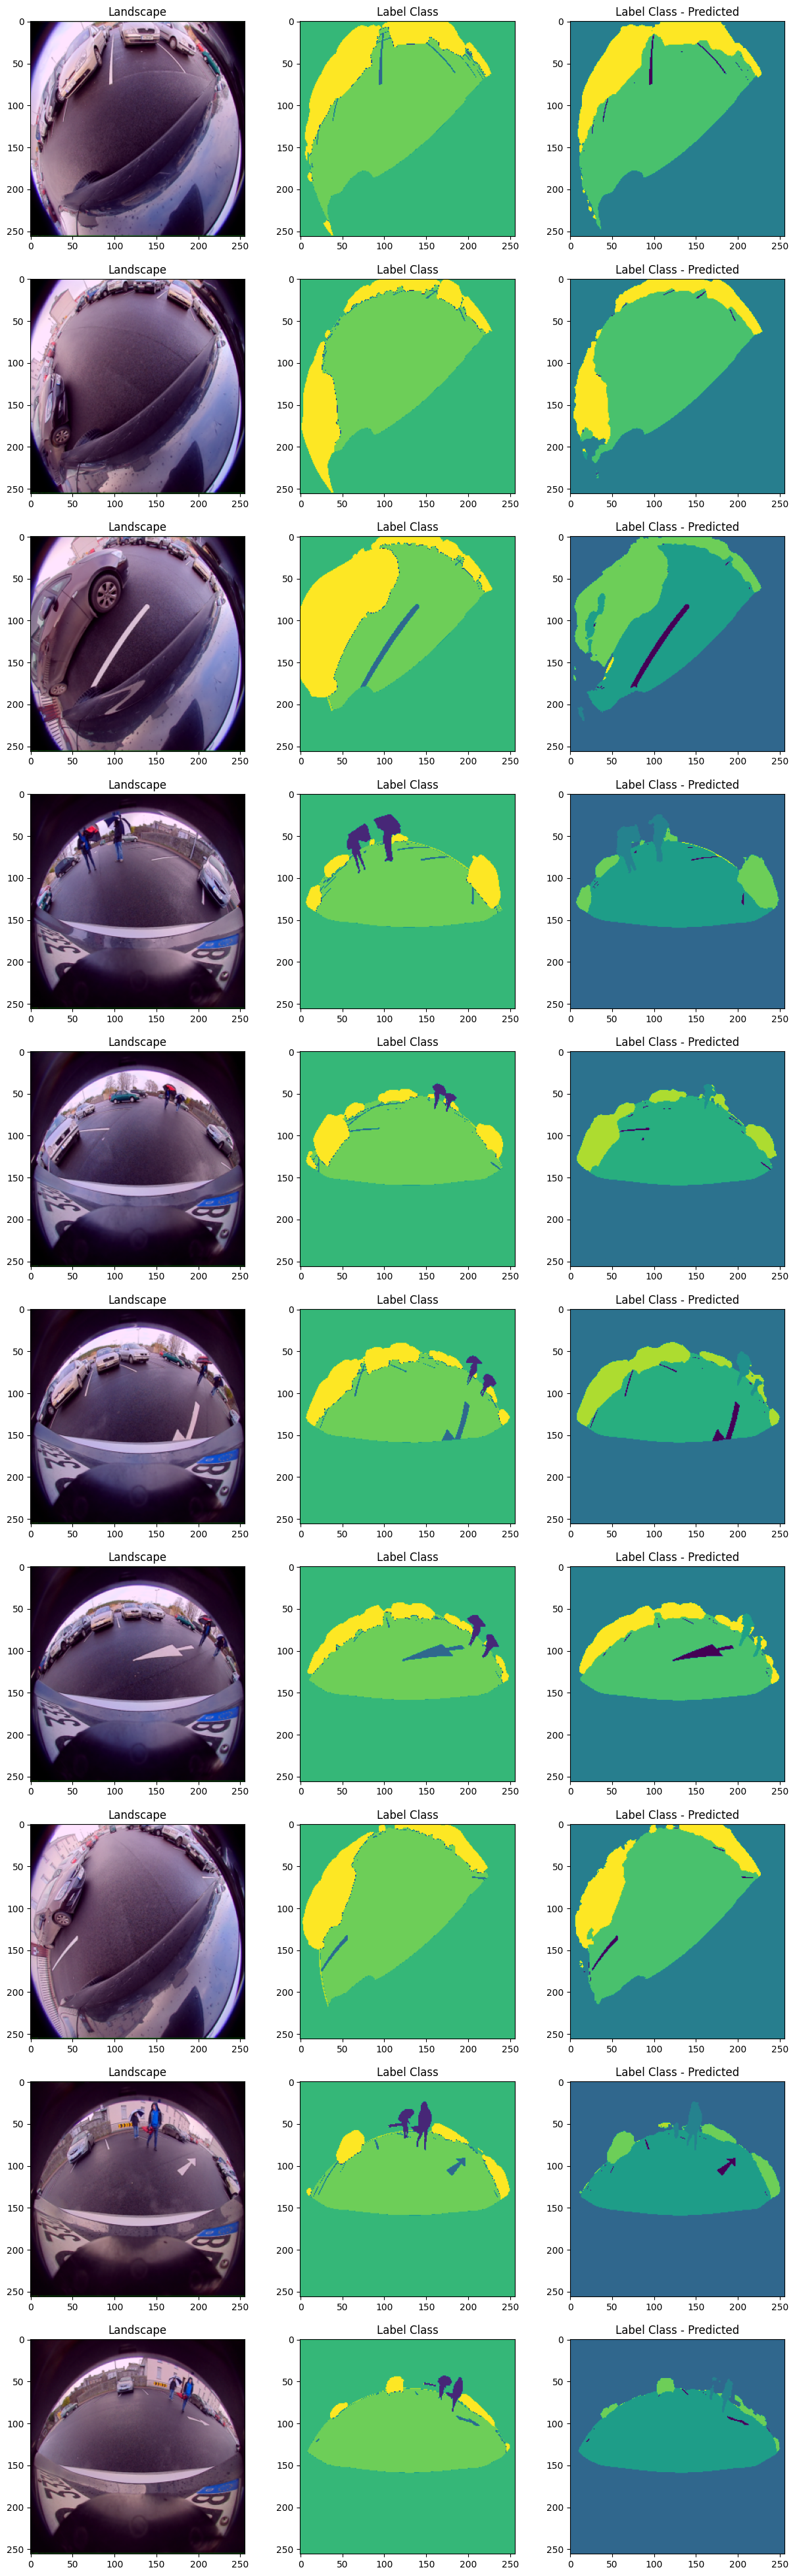

In [26]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [30]:
print("MIOU Score : ",sum(iou_scores) / len(iou_scores))

MIOU Score :  0.9047777777777779


In [31]:
print("Average Prediction Time : ",mean_pred_time)

Average Prediction Time :  1.58595552444458
